In [1]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as T

import matplotlib.image as mpimg

from models import Pix2Pix

# Data

- data URL   
https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz

In [2]:
class CityDataset(Dataset):
    def __init__(self, file_dir, size):
        self.file_dir = file_dir
        self.file_list = os.listdir(file_dir)
        self.size = size
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def resize2d(self, img):
        with torch.no_grad():
            img = (F.adaptive_avg_pool2d(Variable(img), (self.size, self.size))).data
        return img

    def __getitem__(self, index):
        x = mpimg.imread(self.file_dir + self.file_list[index])
        y = x[:,256:,:]
        x = x[:,:256,:]
        x = self.transform(x)
        y = self.transform(y)
        if self.size != 256:
            x = self.resize2d(x)
            y = self.resize2d(y)
        return x, y
 
    def __len__(self):
        return len(self.file_list)

In [3]:
dataset = CityDataset('data/cityscapes/train/', 256)
data_loader = DataLoader(dataset, batch_size=1)

In [4]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

dtype = torch.cuda.FloatTensor
l1_lambda = 100
input_size = 128
d = 64

D = Pix2Pix.Discriminator(d, dtype)
G = Pix2Pix.Genereator(input_size, d, dtype)

G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

torch.cuda.random.manual_seed(12345)
G.apply(reset)
D.apply(reset)

Discriminator(
  (features): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

# LeakyReLU

In [5]:
trainer = Pix2Pix.Trainer(D, D_optimizer, G, G_optimizer, l1_lambda, dtype)

In [6]:
G.encoder

[ConvUp(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.2, inplace)
   )
 ), ConvUp(
   (features): Sequential(
     (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.2, inplace)
   )
 ), ConvUp(
   (features): Sequential(
     (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.2, inplace)
   )
 ), ConvUp(
   (features): Sequential(
     (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.2, inplace)
   )
 ), ConvUp(
   (features): Sequential(
     (0): C

Starting 1/100
Starting 2/100
Starting 3/100
Starting 4/100
Starting 5/100
Time: 351.3194, D loss 0.0000, G loss 40.5920


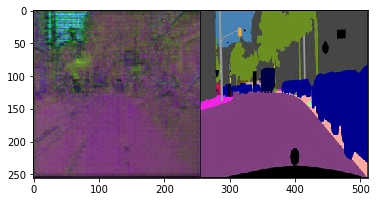

Starting 6/100
Starting 7/100
Starting 8/100
Starting 9/100
Starting 10/100
Time: 351.1213, D loss 0.0000, G loss 48.3793


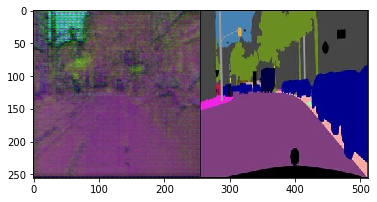

Starting 11/100
Starting 12/100
Starting 13/100
Starting 14/100
Starting 15/100
Time: 341.4926, D loss 0.0000, G loss 46.4646


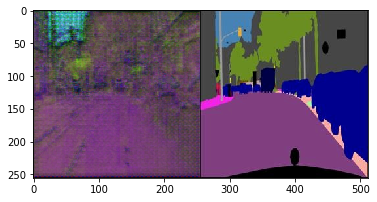

Starting 16/100
Starting 17/100
Starting 18/100
Starting 19/100
Starting 20/100
Time: 343.2182, D loss 0.0000, G loss 51.4205


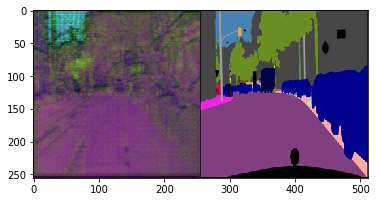

Starting 21/100
Starting 22/100
Starting 23/100
Starting 24/100
Starting 25/100
Time: 342.3874, D loss 0.0000, G loss 53.1313


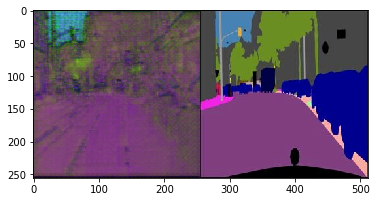

Starting 26/100
Starting 27/100
Starting 28/100
Starting 29/100
Starting 30/100
Time: 342.8338, D loss 0.0000, G loss 53.5918


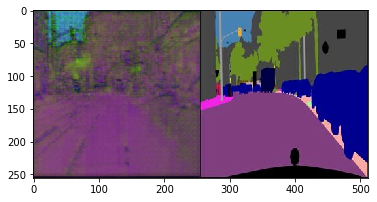

Starting 31/100
Starting 32/100
Starting 33/100
Starting 34/100
Starting 35/100
Time: 341.2114, D loss 0.0000, G loss 53.8373


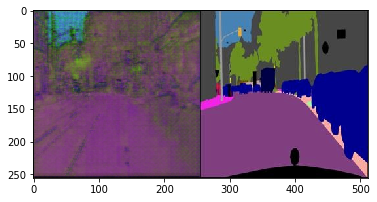

Starting 36/100
Starting 37/100
Starting 38/100
Starting 39/100
Starting 40/100
Time: 354.2688, D loss 0.0000, G loss 54.0200


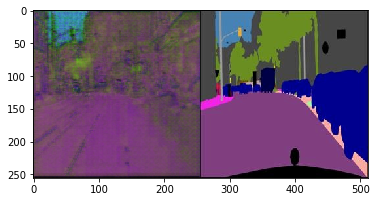

Starting 41/100


KeyboardInterrupt: 

In [7]:
trainer.train(100, data_loader, 5, 1)

In [8]:
torch.save(trainer.D.state_dict(), 'checkpoint/city/190527/discriminator_param.pkl')
torch.save(trainer.G.state_dict(), 'checkpoint/city/190527/generator_param.pkl')